Based on your query, the most relevant image is '/content/drive/MyDrive/Food dataset task 3/pav bhaji.jpg'. Description: No description available.


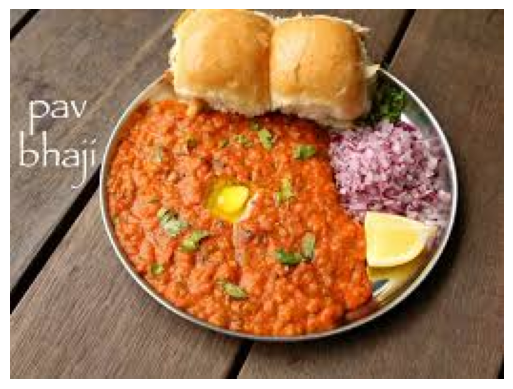

In [24]:
import os
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import faiss
import numpy as np
import matplotlib.pyplot as plt

# Load CLIP model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Function to encode images
def encode_images(image_dir):
    image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(('jpg', 'png'))]
    image_embeddings = []
    image_names = []

    for img_path in image_paths:
        image = Image.open(img_path).convert("RGB")
        inputs = clip_processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            embedding = clip_model.get_image_features(**inputs).cpu().numpy()
        image_embeddings.append(embedding)
        image_names.append(img_path)

    return np.vstack(image_embeddings), image_names

# Load images and encode
image_dir = "/content/drive/MyDrive/Food dataset task 3"
image_embeddings, image_names = encode_images(image_dir)

# Normalize embeddings
image_embeddings = image_embeddings / np.linalg.norm(image_embeddings, axis=1, keepdims=True)

# Create FAISS index
index = faiss.IndexFlatL2(image_embeddings.shape[1])
index.add(image_embeddings)

# Knowledge base
knowledge_base = {
    os.path.join(image_dir, "biriyani.jpg"): "A flavorful Dum Chicken Biryani made with aromatic spices, tender chicken, and basmati rice.",
    os.path.join(image_dir, "idly.jpg"): "Steamed rice cakes typically served with chutneys and sambar.",
    os.path.join(image_dir, "sambar idly.jpg"): "Steamed rice cakes served with a spicy lentil stew.",
    # Add more entries here...
}

# Function to encode text query
def encode_query(query):
    inputs = clip_processor(text=query, return_tensors="pt").to(device)
    with torch.no_grad():
        query_embedding = clip_model.get_text_features(**inputs).cpu().numpy()
    return query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)

# Function to retrieve the most relevant image
def retrieve_image(query):
    query_embedding = encode_query(query)
    _, indices = index.search(query_embedding, k=1)
    retrieved_image = image_names[indices[0][0]]
    return retrieved_image

# Generate response
def generate_response(query):
    retrieved_image = retrieve_image(query)
    description = knowledge_base.get(retrieved_image, "No description available.")
    return f"Based on your query, the most relevant image is '{retrieved_image}'. Description: {description}"

# Display image
def display_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Example query
query = "pav bhaji."
response = generate_response(query)
print(response)

retrieved_image_path = retrieve_image(query)
display_image(retrieved_image_path)
